In [159]:
import os
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import haiku as hk
import jax
import jax.numpy as jnp
import jax.random as jr 
import jraph
import optax
import numpy as np
import matplotlib.pyplot as plt

from mnist_to_graphs import pad_graph_to_value

need to speed up graph batching
* pre-pad nodes to `PAD_VALUE` and batch them? 
* dataload graphs into batches, then vmap select random nodes of each graph

#### globals

In [160]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple

N_GRAPHS = 6000
BATCH_SIZE = 16
N_STEPS = 5_000
PAD_VALUE = 4096 #8128 
F = 8
E = 8

multi_sized = True

#### utils

In [161]:
def print_graph_attributes(g):
    attrs = ["nodes", "edges", "senders", "receivers", "globals", "n_node", "n_edge"]

    for a in attrs:
        val = getattr(g, a)
        print(a, val.shape if val is not None else None)

def adjacency_matrix(sender_indices, receiver_indices, n_nodes=None):
    # Determine the number of nodes in the graph if not provided
    if n_nodes is None:
        n_nodes = max(max(sender_indices), max(receiver_indices)) + 1

    # Create an empty adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))

    # Set entries in the adjacency matrix for each edge
    for sender, receiver in zip(sender_indices, receiver_indices):
        adj_matrix[sender, receiver] = 1 
        adj_matrix[receiver, sender] = 1 

    return adj_matrix

#### data

In [162]:
def get_R_z_string(R_values, z_values, n_moments_calculate=3):
    if isinstance(R_values, list):
        if len(R_values) == len(all_R_values):
            R_string = "all"
        else:
            R_string = "_".join([str(float(R)) for R in R_values])
    else:
        R_string = str(R_values)
    if isinstance(z_values, list):
        if len(z_values) == len(all_redshifts):
            z_string = "all"
        else:
            z_string = "_".join([str(float(z)) for z in z_values])
    else:
        z_string = str(z_values)

    return f"x={resolution}_R={R_string}_z={z_string}_nm={n_moments_calculate}"

prng_seq = hk.PRNGSequence(0)

data_dir = "/Users/Jed.Homer/phd/lfi/jaxdelfi/data/"
resolution = 1024 
all_redshifts = [0., 0.5, 1., 2., 3.]
all_R_values = ["5.0", "10.0", "15.0", "20.0", "25.0", "30.0"]

redshifts = all_redshifts[:1]
R_values = all_R_values[1:4]

R_idx = [all_R_values.index(R) for R in R_values]
z_idx = [redshifts.index(z) for z in redshifts]

print(f"Running for redshifts:\n{redshifts}\nat resolution x={resolution} with R values:\n{R_values}.")

Rz_string = get_R_z_string(R_values, redshifts, n_moments_calculate=3)

Running for redshifts:
[0.0]
at resolution x=1024 with R values:
['10.0', '15.0', '20.0'].


In [163]:
# (z, n, d, R)
all_pdfs = np.load(
    "/Users/Jed.Homer/phd/lfi/jaxdelfi_pdf/data/ALL_PDFS_1024_egg.npy") # downloaded again
all_pdfs_parameters = np.load(
    os.path.join(data_dir, "ALL_PDFS_PARAMS.npy"))

print(all_pdfs.shape)

all_pdfs_z = jnp.stack([all_pdfs[z] for z in z_idx])
all_pdfs_z_R = jnp.stack([all_pdfs_z[..., R] for R in R_idx], axis=-1)
all_pdfs_z_R = all_pdfs_z_R.reshape(2000, 3, -1)
# all_pdfs_z_R = np.moveaxis(all_pdfs_z_R, 1, 0)

all_pdfs_z_R.shape

(5, 2000, 99, 7)


(2000, 3, 99)

#### data
* for each moments datavector, make fully connected subgraph for each redshift, then concatenate all the redshift graphs together...

In [164]:
alpha = jnp.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
parameters = jnp.load(
        os.path.join(data_dir, f"ALL_PDFS_PARAMS.npy")) 
simulations = jnp.load(
    os.path.join(data_dir, f"CALCULATED_PDF_MOMENTS_{Rz_string}.npy"))
fiducial_dv = jnp.load(
    os.path.join(data_dir, f'fiducial_moments_unflat_{Rz_string}.npy')).mean(axis=0)

n_sims, parameter_dim = parameters.shape
n_z, n_R, n_m = fiducial_dv.shape
data_dim = np.prod(fiducial_dv.shape)

n_multiples = N_GRAPHS // len(parameters)
parameters = jnp.tile(parameters, (n_multiples, 1))
simulations = jnp.tile(simulations, (n_multiples, 1, 1, 1))

parameters.shape, simulations.shape, fiducial_dv.shape

((6000, 5), (6000, 1, 3, 3), (1, 3, 3))

In [165]:
# simulations = all_pdfs_z_R
data_dim = np.prod(simulations.shape[1:])

#### graph builders

In [166]:
fiducial_dv[0], fiducial_dv[0].flatten()

(DeviceArray([[0.5789486 , 1.3066869 , 6.6244755 ],
              [0.28116238, 0.27146104, 0.706583  ],
              [0.16624273, 0.08836116, 0.16433717]], dtype=float32),
 DeviceArray([0.5789486 , 1.3066869 , 6.6244755 , 0.28116238, 0.27146104,
              0.706583  , 0.16624273, 0.08836116, 0.16433717],            dtype=float32))

In [167]:
def make_subgraphs(moments, n_idx=None, deselect_rng=None):
    """ 
        Pass in as many integers as moments for each R, z moment vector 
    """
    # Vmapping, so this is z-axis
    all_g_z = []
    for i, (z, mz) in enumerate(zip(redshifts, moments)):
        # Give every node (a moment) R and z information
        n_R, n_m = mz.shape
        Rs = jnp.array(
            [float(R) for R in R_values] * n_m)
        zs = jnp.array(
            [z] * n_R * n_m)
        # print(mz.shape, np.prod(mz.shape))
        # print([_.shape for _ in [mz.flatten(), Rs, zs]])

        # Randomly de-select nodes  
        node_datas = [mz.flatten(), Rs, zs]
        print([_.shape for _ in node_datas])
        node_features = jnp.stack(node_datas, axis=1)
        if deselect_rng is not None and n_idx is not None:
            rng_n, rng_i = jr.split(deselect_rng)
            # Random number of nodes to deselect
            # n_idx = jr.randint(
            #     rng_n, (1,), 0, np.prod(fiducial_dv.shape) - 1)
            # A random number of nodes chosen
            p = jax.nn.softmax(jnp.exp(-jnp.arange(len(node_features))))
            node_idx = jnp.arange(len(node_features))
            idx = jr.choice(
                rng_i, node_idx, (n_idx[i],), p=None, replace=False)
            
            node_features_ = node_features[idx]
            n_node_per_graph = len(node_features_)
        else:
            node_features_ = node_features
            n_node_per_graph = np.prod(mz.shape)
        print(n_node_per_graph, node_features.shape)

        g_z = jraph.get_fully_connected_graph(
            node_features=node_features_,
            n_node_per_graph=n_node_per_graph,
            n_graph=1,
            global_features=None,
            #global_features=parameters, # maybe just parameters for main_graph not subgraphs?
            add_self_edges=True)
        all_g_z.append(g_z)
    return all_g_z 

def make_graph_from_subgraphs(subgraphs, parameters=None):
    """ 
        Make ONE graph from fully connected redshift-subgraphs
        - NO connections between subgraphs of different redshift
    """
    n_node = sum([g_z.n_node for g_z in subgraphs])
    n_edge = sum([g_z.n_edge for g_z in subgraphs])
    # Note: n_edge is redundant for one redshift + fully connected
    cardinality = jnp.array([n_node, n_edge]).astype(jnp.float32)
    cardinality = cardinality.reshape(1, 2)
    return jraph.GraphsTuple(
        nodes=jnp.concatenate([
            g_z.nodes for g_z in subgraphs]),
        edges=None, 
        # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
        senders=jnp.concatenate([
            g_z.n_node * n + g_z.senders 
            for n, g_z in enumerate(subgraphs)]),
        receivers=jnp.concatenate([
            g_z.n_node * n + g_z.receivers 
            for n, g_z in enumerate(subgraphs)]),
        n_node=n_node,
        n_edge=n_edge,
        globals=cardinality)

In [168]:
import tensorflow as tf

In [169]:
simulations.shape

(6000, 1, 3, 3)

In [170]:
dataset = tf.data.Dataset.from_tensor_slices(
    #(xy for xy in zip(simulations, parameters)))
    (simulations, parameters))
dataset = dataset.repeat().batch(batch_size=BATCH_SIZE)
dataset = dataset.as_numpy_iterator()
x, y = next(dataset)
print(x.shape, y.shape)

g = jax.vmap(make_subgraphs)(x)
# print(len(g[0].n_node))
print("\n")
print_graph_attributes(g[0])
# print(len(g))
# print([g.n_node)

(16, 1, 3, 3) (16, 5)
[(9,), (9,), (9,)]
9 (9, 3)


nodes (16, 9, 3)
edges None
senders (16, 81)
receivers (16, 81)
globals None
n_node (16, 1)
n_edge (16, 1)


In [171]:
def make_graph(data, n_idx=None, rng=None):
    # rng, n_idx == None => same sized graphs
    g = make_graph_from_subgraphs(
        make_subgraphs(data, n_idx, rng))
    # g = g._replace(
    #     globals=g.globals.squeeze())
    return g

g = jax.vmap(make_graph)(x)

print_graph_attributes(g)

[(9,), (9,), (9,)]
9 (9, 3)
nodes (16, 9, 3)
edges None
senders (16, 81)
receivers (16, 81)
globals (16, 1, 2)
n_node (16, 1)
n_edge (16, 1)


In [172]:
# now try deselecting node features in main_graph of subgraphs

# def remove_random_nodes(graph, rng, ):
#     rng_i, rng_n = jr.split(rng)
#     n_nodes = jr.randint(rng_n, )
#     g = g.

In [173]:
# @jax.jit
# def scatter_zeros(x, n):
#     i = jnp.zeros_like()
    

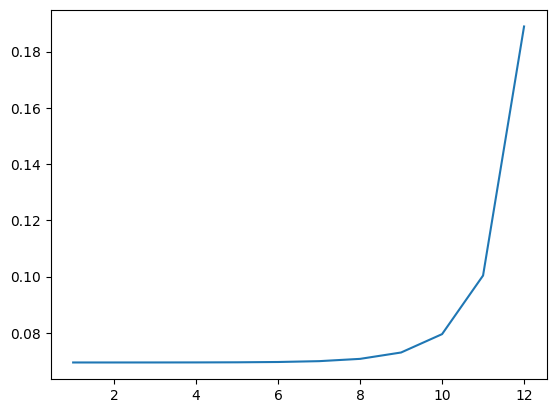

12

In [206]:
# weighting for graph n_node selection
p = jax.nn.softmax(jnp.exp(-jnp.arange(12)))
plt.plot(jnp.arange(12, 0, -1), p)
plt.show()
len(jnp.arange(12))

In [175]:
subgraphs = make_subgraphs(fiducial_dv)
print("subgraph")
print_graph_attributes(subgraphs[0])

main_graph = make_graph_from_subgraphs(subgraphs, alpha)
print("\nmaingraph")
print_graph_attributes(main_graph)

main_graph.nodes.shape, main_graph.edges, main_graph.globals, main_graph.senders.shape, main_graph.receivers.shape, main_graph.globals.shape

[(9,), (9,), (9,)]
9 (9, 3)
subgraph
nodes (9, 3)
edges None
senders (81,)
receivers (81,)
globals None
n_node (1,)
n_edge (1,)

maingraph
nodes (9, 3)
edges None
senders (81,)
receivers (81,)
globals (1, 2)
n_node (1,)
n_edge (1,)


((9, 3), None, DeviceArray([[ 9., 81.]], dtype=float32), (81,), (81,), (1, 2))

In [176]:
rng = jr.PRNGKey(0)

In [177]:
# De-select at most n_moments - 1 elements
rng, _ = jr.split(rng)

# For each redshift graph, drop as many as 
# n_nodes - 1 nodes from the graph.

# at minimum choose 
p = jax.nn.softmax(jnp.exp(-jnp.arange(0, n_R * n_m - 1)))
# n_idx = jr.randint(rng, (n_z,), 0, n_R * n_m - 1)
n_idx = jr.choice(rng, jnp.arange(0, n_R * n_m - 1), (n_z,), p=p, replace=False)
print(n_idx)

subgraphs = make_subgraphs(
    fiducial_dv, 
    n_idx if n_idx > 0 else None, 
    rng)
print("subgraph")
print_graph_attributes(subgraphs[0])

main_graph = make_graph_from_subgraphs(subgraphs, alpha)
print("\nmaingraph")
print_graph_attributes(main_graph)

main_graph.nodes.shape, main_graph.edges, main_graph.globals, main_graph.senders.shape, main_graph.receivers.shape, main_graph.globals.shape

[1]
[(9,), (9,), (9,)]
1 (9, 3)
subgraph
nodes (1, 3)
edges None
senders (1,)
receivers (1,)
globals None
n_node (1,)
n_edge (1,)

maingraph
nodes (1, 3)
edges None
senders (1,)
receivers (1,)
globals (1, 2)
n_node (1,)
n_edge (1,)


((1, 3), None, DeviceArray([[1., 1.]], dtype=float32), (1,), (1,), (1, 2))

In [178]:
main_graph.senders.max()

DeviceArray(0, dtype=int32)

In [179]:
print_graph_attributes(main_graph)

nodes (1, 3)
edges None
senders (1,)
receivers (1,)
globals (1, 2)
n_node (1,)
n_edge (1,)


In [180]:
if None:
    # Expect three squares on diagonal: FULLY connected subgraphs
    A = adjacency_matrix(main_graph.senders, main_graph.receivers)
    plt.imshow(A, cmap="gray_r")
    print(A.mean())
    plt.show()

#### model

##### resnet

In [181]:
layernorm_kwargs = dict(
  axis=1, create_scale=True, create_offset=True, eps=1e-8)

class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = jax.nn.leaky_relu,
    activate_final: bool = False):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final

  def __call__(self, x):
    # assert x.shape[-1] == self.hidden_size, (
    #   "Input must be hidden size.")
    z = x
    for f in self.hidden_sizes:
      h = self.activation(z)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f)(h)
      h = self.activation(h)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f, w_init=jnp.zeros)(h)
      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [182]:
@jraph.concatenated_args
def edge_update_fn(feats: Array) -> Array:
  """ Edge update function for graph net. """
  net = hk.Sequential([
    # hk.Linear(F), 
    LinearResNet([F, F, F])])
    # hk.Linear(F), hk.nets.MLP([F, F, F], activation=jax.nn.tanh)])
  return net(feats)

@jraph.concatenated_args 
def node_update_fn(feats: Array) -> Array:
  """ Node update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
    # hk.Linear(F), 
    # hk.nets.MLP([F, F, F], activation=jax.nn.tanh)])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: Array) -> Array:
  """ Global update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), 
    #LinearResNet([F, F, F], activate_final=True),
    # hk.nets.MLP([F, F, F], activation=jax.nn.tanh, activate_final=True),
    hk.Linear(parameter_dim, with_bias=True)]) # output summary of parameter dim
  return net(feats)

def LayerNormLinear(x):
    h = hk.LayerNorm(**layernorm_kwargs)(x)
    return hk.Linear(E, with_bias=False)(h)

def net_fn(graph: Graph) -> Graph:
  """ 
    Default aggregator functions for edges, global edges, global nodes 
    are "segment_sum"
  """
  embedder = jraph.GraphMapFeatures(
    embed_node_fn=LayerNormLinear, 
    embed_global_fn=LayerNormLinear) 
  graph = embedder(graph)
  for _ in range(1):
    net = jraph.GraphNetwork(
        update_edge_fn=None,
        update_node_fn=node_update_fn,
        update_global_fn=update_global_fn)
    graph = net(graph)
  return graph

#### train

#### trainer functions

In [183]:
if None:
    rng, _ = jr.split(rng)

    def make_graph(data, n_idx, rng):
        # rng, rng_ = jr.split(rng)
        # for idx in n_idx:
        #     i_idx = jr.choice(rng, jnp.arange(1, n_R * n_m), (n_idx[0],))
        return make_graph_from_subgraphs(
            make_subgraphs(data, n_idx, rng))# > 0 else None, rng_))

    all_n_idx = jr.randint(rng, (n_multiples * n_sims, n_z), 0, n_R * n_m)
    all_i_idx = jr.randint(rng, (n_multiples * n_sims, n_R * n_m), 0, n_R * n_m)

    g = make_graph(fiducial_dv, all_n_idx[0], rng)
    print_graph_attributes(g)

    #graphs = jax.vmap(make_graph)(simulations, all_n_idx, jr.split(rng, n_multiples * n_sims))

    # This works
    if not multi_sized:
        # graphs = jax.vmap(partial(make_graph, n_idx=None, rng=None))(simulations)
        graphs = jax.vmap(make_graph, in_axes=(0, None, None))(simulations, None, None)
        print(len(graphs.n_node))
    else:
        graphs = jax.vmap(partial(make_graph, n_idx=None, rng=None))(simulations)
        print(len(graphs.n_node))

In [184]:
dataset_processed = []
for n in range(N_GRAPHS):
    if multi_sized:
        rng, deselect_rng = jr.split(rng, 2)
        # Never selects 0???
        n_idx = jr.randint(
            rng, (n_z,), 1, n_R * n_m)
        print(n_idx)
        g_z = make_subgraphs(
            simulations[n], 
            n_idx,# if n_idx > 0 else None, 
            deselect_rng) 
    else:
        g_z = make_subgraphs(simulations[n]) 
    l = parameters[n]
    g = make_graph_from_subgraphs(g_z, l[None, :]) # pointless 'l' here it is removed later anyway...
    dataset_processed.append(dict(input_graph=g, target=l))

[3]
[(9,), (9,), (9,)]
3 (9, 3)
[4]
[(9,), (9,), (9,)]
4 (9, 3)
[8]
[(9,), (9,), (9,)]
8 (9, 3)
[7]
[(9,), (9,), (9,)]
7 (9, 3)
[5]
[(9,), (9,), (9,)]
5 (9, 3)
[8]
[(9,), (9,), (9,)]
8 (9, 3)
[2]
[(9,), (9,), (9,)]
2 (9, 3)
[2]
[(9,), (9,), (9,)]
2 (9, 3)
[6]
[(9,), (9,), (9,)]
6 (9, 3)
[7]
[(9,), (9,), (9,)]
7 (9, 3)
[8]
[(9,), (9,), (9,)]
8 (9, 3)
[4]
[(9,), (9,), (9,)]
4 (9, 3)
[5]
[(9,), (9,), (9,)]
5 (9, 3)
[2]
[(9,), (9,), (9,)]
2 (9, 3)
[4]
[(9,), (9,), (9,)]
4 (9, 3)
[7]
[(9,), (9,), (9,)]
7 (9, 3)
[8]
[(9,), (9,), (9,)]
8 (9, 3)
[7]
[(9,), (9,), (9,)]
7 (9, 3)
[7]
[(9,), (9,), (9,)]
7 (9, 3)
[7]
[(9,), (9,), (9,)]
7 (9, 3)
[8]
[(9,), (9,), (9,)]
8 (9, 3)
[7]
[(9,), (9,), (9,)]
7 (9, 3)
[2]
[(9,), (9,), (9,)]
2 (9, 3)
[4]
[(9,), (9,), (9,)]
4 (9, 3)
[7]
[(9,), (9,), (9,)]
7 (9, 3)
[5]
[(9,), (9,), (9,)]
5 (9, 3)
[7]
[(9,), (9,), (9,)]
7 (9, 3)
[3]
[(9,), (9,), (9,)]
3 (9, 3)
[8]
[(9,), (9,), (9,)]
8 (9, 3)
[5]
[(9,), (9,), (9,)]
5 (9, 3)
[6]
[(9,), (9,), (9,)]
6 (9, 3)
[6]
[(9,

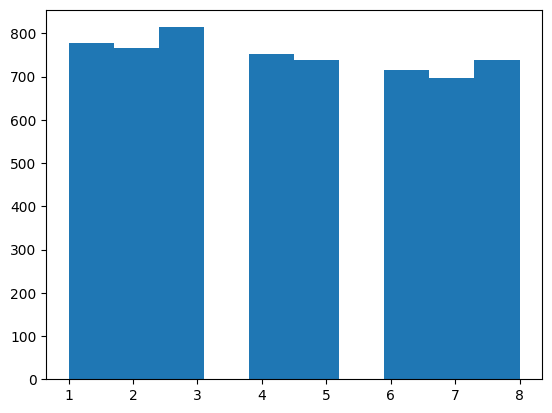

In [185]:
if multi_sized:
    all_n_nodes = [
        # d["input_graph"].globals[0, 0].squeeze() 
        d["input_graph"].n_node.squeeze()
        for d in dataset_processed]
    # print(all_n_nodes)
    plt.figure()
    plt.hist(all_n_nodes, bins=10)
    plt.show()


In [186]:
g = dataset_processed[0]["input_graph"]
print_graph_attributes(g)

nodes (3, 3)
edges None
senders (9,)
receivers (9,)
globals (1, 2)
n_node (1,)
n_edge (1,)


In [187]:
gs, ls = [], []
for _ in range(5):
    gl = dataset_processed[_]
    g, l = gl.values()
    gs.append(g), ls.append(l)

g_all = jraph.batch(gs)
print([g.nodes.shape for g in gs])
g_all.nodes.shape
print(g_all.n_node)
print(g_all.n_edge)

print_graph_attributes(g_all)

[(3, 3), (4, 3), (8, 3), (7, 3), (5, 3)]
[3 4 8 7 5]
[ 9 16 64 49 25]
nodes (27, 3)
edges None
senders (163,)
receivers (163,)
globals (5, 2)
n_node (5,)
n_edge (5,)


In [188]:
dataset_processed[0]["target"].shape

(5,)

In [189]:
def compute_loss(
  params: hk.Params, 
  graph: Graph, 
  label: Array,
  net: Graph) -> Tuple[Array, Array]:
  """Computes loss and accuracy."""

  pred_graph = net.apply(params, graph)
  print("pred graph globals", pred_graph.globals.shape)

  # Output of GNN and target: one hot encoded MNIST labels
  # preds = jax.nn.log_softmax(pred_graph.globals)
  preds = pred_graph.globals

  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  print("PREDS/TARGETS", preds.shape, label.shape)
  # loss = -(preds * label * mask[:, None]).mean()
  loss = (jnp.square(jnp.subtract(preds, label)) * mask[:, None]).mean()

  return loss, (None,)
 

def train(
  dataset: List[Dict[str, Any]], 
  num_train_steps: int) -> Tuple[hk.Params, List, List]:

  key = jr.PRNGKey(0)

  net = hk.without_apply_rng(hk.transform(net_fn))

  graph = dataset[0]['input_graph']
  graph = pad_graph_to_value(graph, PAD_VALUE)
  params = net.init(key, graph)

  print(f"n_params = {sum(x.size for x in jax.tree_util.tree_leaves(params)):.2E}")

  # Initialize the optimizer.
  opt_init, opt_update = optax.adabelief(2e-4)
  opt_state = opt_init(params)

  compute_loss_fn = partial(compute_loss, net=net)
  compute_loss_fn = jax.jit(
    jax.value_and_grad(compute_loss_fn, has_aux=True))

  losses, accs = [], []
  for s in range(num_train_steps):
    key, key_idx = jr.split(key)

    idx = jr.randint(key_idx, shape=(BATCH_SIZE,), minval=0, maxval=N_GRAPHS)
    if BATCH_SIZE > 1:
        gs, ls = [], []
        for i in idx:
            g, l = dataset[int(i)].values()
            gs.append(g), ls.append(l)
        graph = jraph.batch(gs)
        label = jnp.stack(ls)
    else:
        graph, label = dataset[int(idx)].values()

    """ Should remove graph label, for model to generate itself. """
    # graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
    graph = pad_graph_to_value(graph, PAD_VALUE)

    # Since padding is implemented with pad_with_graphs, an extra graph has
    # been added to the batch, which means there should be an extra label.
    """ This label gets masked out. """
    label = jnp.concatenate([label, jnp.zeros((1, parameter_dim))])

    (loss, (_)), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

    if s % 100 == 0:
      print(f'\rstep: {s:06d}, loss: {loss:.4f}', end="")
    losses.append(loss)

  print('Training finished')
  return params, losses, accs

#### check

In [190]:
print([_.shape for _ in g_all if _ is not None])
print_graph_attributes(g_all)

[(27, 3), (163,), (163,), (5, 2), (5,), (5,)]
nodes (27, 3)
edges None
senders (163,)
receivers (163,)
globals (5, 2)
n_node (5,)
n_edge (5,)


In [191]:
key = jr.PRNGKey(0)
key, _ = jr.split(key)

net = hk.without_apply_rng(hk.transform(net_fn))

graph = pad_graph_to_value(g_all, PAD_VALUE)
print(graph.globals, graph.globals.shape)

params = net.init(key, g_all)

y_ = net.apply(params, g_all)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print(mask)

jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[[ 3.  9.]
 [ 4. 16.]
 [ 8. 64.]
 [ 7. 49.]
 [ 5. 25.]
 [ 0.  0.]] (6, 2)
net out (5, 5)
[ True  True  True  True False]


(DeviceArray([1, 1, 1, 1], dtype=int32), DeviceArray(3, dtype=int32))

In [192]:
key = jr.PRNGKey(0)
key, _ = jr.split(key)

net = hk.without_apply_rng(hk.transform(net_fn))

ix1, ix2 = jr.randint(key, (2,), 0, len(dataset_processed))

graph = dataset_processed[ix1]['input_graph']
l = dataset_processed[ix1]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print(graph.globals, graph.globals.shape)

print_graph_attributes(graph)

params = net.init(key, graph)

graph = dataset_processed[ix2]['input_graph']
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)

y_ = net.apply(params, graph)
print("net out", y_.globals.shape)

mask = jraph.get_graph_padding_mask(y_)
print(mask)

jnp.argmax(y_.globals[mask], axis=1), l.argmax()

[[3. 9.]
 [0. 0.]] (2, 2)
nodes (4097, 3)
edges None
senders (4096,)
receivers (4096,)
globals (2, 2)
n_node (2,)
n_edge (2,)
net out (2, 5)
[ True False]


(DeviceArray([1], dtype=int32), DeviceArray(3, dtype=int32))

In [193]:
graph = dataset_processed[ix2]['input_graph']
print("before pad", graph.nodes.shape, graph.globals.shape)
l = dataset_processed[ix2]['target']
graph = pad_graph_to_value(graph, PAD_VALUE)
print("after pad", graph.nodes.shape, graph.globals.shape)

before pad (1, 3) (1, 2)
after pad (4097, 3) (2, 2)


In [194]:
import time
t0 = time.time()

params, losses, accs = train(dataset_processed, num_train_steps=N_STEPS)

print(f"\n {(time.time() - t0) / 60.:.2f} mins.")

n_params = 8.95E+02
pred graph globals (17, 5)
PREDS/TARGETS (17, 5) (17, 5)
step: 004900, loss: 0.0083Training finished

 5.82 mins.


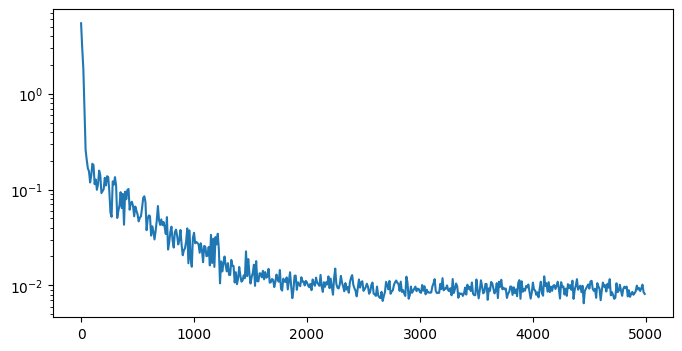

In [195]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8.,4.))
steps = range(0, N_STEPS, 10)
ax.semilogy(steps, losses[::10])
plt.show()

In [196]:
graphs = []
for gl in dataset_processed:
    g, l = gl.values()
    graphs.append(g)

all_graphs = jraph.batch(graphs)

print_graph_attributes(all_graphs)

nodes (26532, 3)
edges None
senders (148816,)
receivers (148816,)
globals (6000, 2)
n_node (6000,)
n_edge (6000,)


In [197]:
fiducial_subgraphs = make_subgraphs(fiducial_dv)
fiducial_graph = make_graph_from_subgraphs(fiducial_subgraphs, alpha[None, :])

[(9,), (9,), (9,)]
9 (9, 3)


In [198]:
all_graphs_out = net.apply(params, all_graphs)
fiducial_graph_out = net.apply(params, fiducial_graph)

preds = all_graphs_out.globals
fiducial_preds = fiducial_graph_out.globals

fiducial_preds.shape 

(1, 5)

In [199]:
# List of graphs
if None:
    unbatched_graphs = jraph.unbatch(all_graphs_out)
    isinstance(unbatched_graphs, list)

    A = adjacency_matrix(unbatched_graphs[0].senders, unbatched_graphs[0].receivers)
    plt.imshow(A, cmap="gray_r")
    plt.show()

senders and receivers are constant through application of graph interaction network

In [200]:
if None:
    A = adjacency_matrix(fiducial_graph_out.senders, fiducial_graph_out.receivers)
    plt.imshow(A, cmap="gray_r")
    print(A.mean())
    plt.show()

(6000, 2) (6000, 2)
1 8


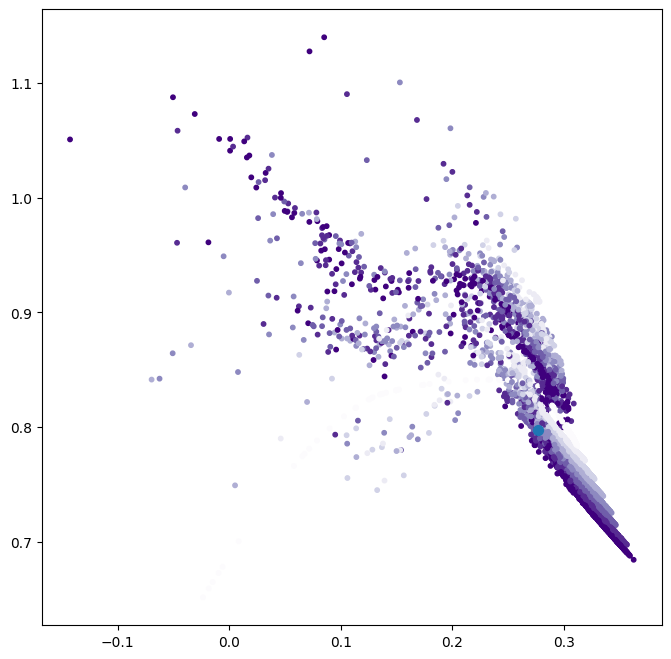

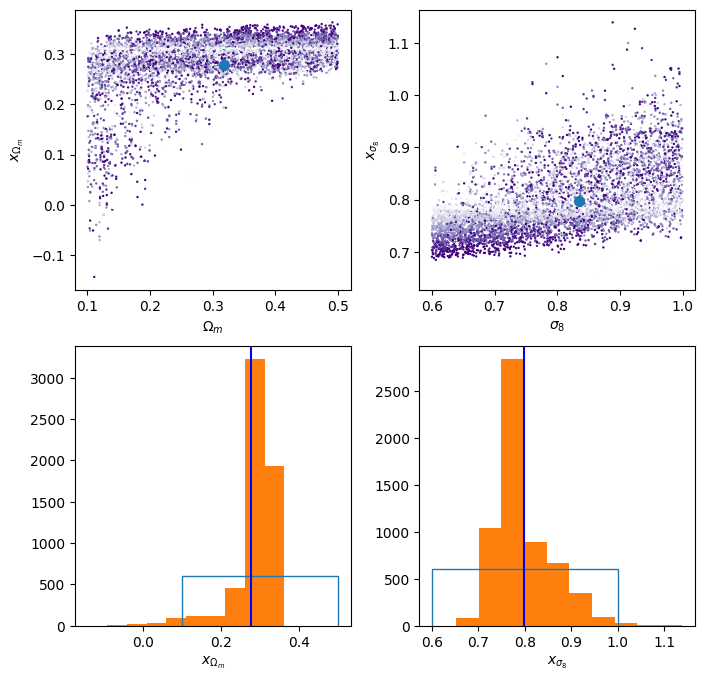

In [201]:
cmap = "Purples"

target_idx = jnp.array([0, 4])
pred_targets = preds[:, target_idx]
parameter_targets = parameters[:N_GRAPHS, target_idx]

print(pred_targets.shape, parameter_targets.shape)
print(min(all_n_nodes), max(all_n_nodes))

plt.figure(figsize=(8., 8.), dpi=100)
plt.scatter(*pred_targets.T, c=all_n_nodes, cmap=cmap, s=10.)
plt.scatter(*fiducial_preds[:, target_idx].T, s=50.)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(8., 8.), dpi=100)
ax = axs[0, 0]
ax.scatter(parameter_targets[:, 0], pred_targets[:, 0], c=all_n_nodes, s=0.5, cmap=cmap)
ax.scatter(alpha[None, :][:, 0], fiducial_preds[:, 0], s=50.)
ax.set_ylabel("$x_{\Omega_m}$")
ax.set_xlabel("$\Omega_m$")
ax = axs[0, 1]
ax.scatter(parameter_targets[:, 1], pred_targets[:, 1], c=all_n_nodes, s=0.5, cmap=cmap)
ax.scatter(alpha[None, :][:, 4], fiducial_preds[:, 4], s=50.)
ax.set_ylabel("$x_{\sigma_8}$")
ax.set_xlabel("$\sigma_8$")
ax = axs[1, 0]
ax.hist(parameter_targets[:, 0], histtype="step")
ax.hist(pred_targets[:, 0])
ax.axvline(fiducial_preds[:, 0], color="blue")
ax.set_xlabel("$x_{\Omega_m}$")
ax = axs[1, 1]
ax.hist(parameter_targets[:, 1], histtype="step")
ax.hist(pred_targets[:, 1])
ax.set_xlabel("$x_{\sigma_8}$")
ax.axvline(fiducial_preds[:, 4], color="blue")
plt.subplots_adjust(wspace=0.25)
plt.show()

In [202]:
fiducial_preds.shape

(1, 5)

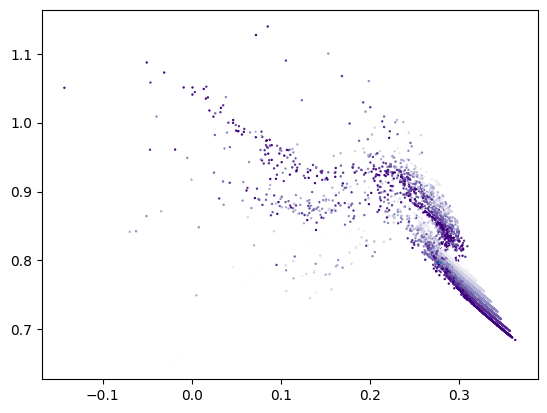

In [203]:
plt.figure()
plt.scatter(*pred_targets.T, s=0.5, c=all_n_nodes, cmap=cmap)
plt.scatter(*fiducial_preds[:, target_idx].T, s=2.)
plt.show()